In [1]:
import numpy as np
from rasterio.windows import Window
from typing import List
import os
import rasterio
import torch
import matplotlib.pyplot as plt

In [2]:
def reconstruct_image_from_tiles(tiles: List[Window], image_width: int, image_height: int, tile_size: int, overlap: int) -> np.ndarray:
    """
    Reconstruct the original image from the list of tiles.

    Parameters:
        tiles (List[Window]): A list of rasterio Window objects representing each tile.
        image_width (int): The width of the original image in pixels.
        image_height (int): The height of the original image in pixels.
        tile_size (int): The size of each tile (assumes square tiles).
        overlap (int): The number of overlapping pixels between adjacent tiles.

    Returns:
        np.ndarray: A numpy array representing the reconstructed image.
    """
    # Calculate step size
    step_size = tile_size - overlap
    
    # Create an empty array to hold the reconstructed image as float
    reconstructed_image = np.zeros((image_height, image_width), dtype=np.float32)
    
    # Create an array to count how many times each pixel is written to
    pixel_count = np.zeros((image_height, image_width), dtype=int)

    # Place each tile back into the reconstructed image
    for window in tiles:
        x_start = window.col_off
        y_start = window.row_off
        
        # Read the tile data (this part would normally come from your data source)
        # For demonstration purposes, we will create a dummy tile data here.
        tile_data = np.ones((tile_size, tile_size), dtype=np.uint8) * 255  # Replace with actual tile data
        
        # Calculate end positions for height and width
        height_end = min(y_start + window.height, image_height)
        width_end = min(x_start + window.width, image_width)

        # Check if the calculated sizes are valid
        if height_end > y_start and width_end > x_start:
            reconstructed_image[y_start:height_end, x_start:width_end] += tile_data[:height_end - y_start, :width_end - x_start]
            pixel_count[y_start:height_end, x_start:width_end] += 1

    # Handle averaging where pixels are counted multiple times due to overlap
    with np.errstate(divide='ignore', invalid='ignore'):
        reconstructed_image = np.divide(reconstructed_image, pixel_count,
                                         out=np.zeros_like(reconstructed_image),
                                         where=pixel_count != 0)

    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
    
    return reconstructed_image



In [3]:
def create_windows_from_paths(tile_files: List[str], tile_size: int, overlap: int) -> List[Window]:
    """
    Create Window objects from file paths based on their positions.

    Parameters:
        tile_files (List[str]): List of file paths for the tiles.
        tile_size (int): The size of each tile (assumes square tiles).
        overlap (int): The number of overlapping pixels between adjacent tiles.

    Returns:
        List[Window]: A list of rasterio Window objects representing each tile.
    """
    step_size = tile_size - overlap
    windows = []

    for tile_file in tile_files:
        # Extract the tile index from the filename
        # Assuming filenames are in the format 'tile_{row}_{col}.tif'
        basename = os.path.basename(tile_file)
        parts = basename.split('_')
        
        if len(parts) != 3:
            raise ValueError(f"Filename '{basename}' does not match expected format.")

        row = int(parts[1])
        col = int(parts[2].split('.')[0])  # Remove file extension
        
        # Calculate the offsets for the Window
        x_offset = col * step_size
        y_offset = row * step_size
        
        # Create the Window object
        window = Window(x_offset, y_offset, tile_size, tile_size)
        windows.append(window)

    return windows

In [4]:

output_folder = 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder'
tile_files = [
        os.path.join(output_folder, 'images', f)
        for f in os.listdir(os.path.join(output_folder, 'images'))
        if f.startswith(f'tile_{2}_')
    ]
print(tile_files)

['D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_0.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_1.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_2.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_3.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_4.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_5.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_6.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_7.tif', 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder\\images\\tile_2_8.tif']


In [5]:
# Пример использования функции
# Предположим у вас есть список объектов Window и размеры изображения
image_width = 512
image_height = 512
tile_size = 256
overlap = 32
tile_windows = create_windows_from_paths(tile_files, 256, 32)
print(tile_windows)
# Создание объектов Window на основе путей к файлам тайлов (пример)
# Примерный код для создания объектов Window здесь...

# Восстановление изображения из тайлов
picture = reconstruct_image_from_tiles(tile_windows, image_width, image_height, tile_size, overlap)
print(picture)

[Window(col_off=0, row_off=448, width=256, height=256), Window(col_off=224, row_off=448, width=256, height=256), Window(col_off=448, row_off=448, width=256, height=256), Window(col_off=672, row_off=448, width=256, height=256), Window(col_off=896, row_off=448, width=256, height=256), Window(col_off=1120, row_off=448, width=256, height=256), Window(col_off=1344, row_off=448, width=256, height=256), Window(col_off=1568, row_off=448, width=256, height=256), Window(col_off=1792, row_off=448, width=256, height=256)]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [6]:
def save_image_as_tiff(image_array: np.ndarray, output_path: str) -> None:
    """
    Save a NumPy array as a TIFF image using rasterio.

    Parameters:
        image_array (np.ndarray): The NumPy array representing the image.
        output_path (str): The file path where the TIFF image will be saved.

    Returns:
        None
    """
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=image_array.shape[0],
        width=image_array.shape[1],
        count=10,  # Assuming a single-band image; change if multi-band
        dtype='uint8'
    ) as dst:
        dst.write(image_array, 1)

In [7]:
save_image_as_tiff(picture, 'D:/hacaton/2/train_dataset_skoltech_train/train/output_folder/output_image.tif')

d:\hacaton\2\train_dataset_skoltech_train\venv\Lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [8]:
def tiff_to_tensor(tif_path):
    """
    Читает все каналы из файла.
    Обрезает верхнюю границу значений пикселей.
    Нормализация по текущему изображению.
    
    Parameters:
    - tif_path: Путь до изображения.
    
    Returns:
    - torch.Tensor: Обработанное изображение.
    """
    with rasterio.open(tif_path) as src:
        # Читаем все каналы изображения и преобразуем в numpy-массив
        img_array = src.read()  # Получаем массив с форматом (channels, height, width)
    img_tensor = torch.from_numpy(img_array).float()
    img_tensor = torch.clamp(img_tensor, min = 0, max = 5000)
    img_tensor = img_tensor / 5000
    return img_tensor

In [9]:
tensor = tiff_to_tensor('D:/hacaton/2/train_dataset_skoltech_train/train/output_folder/output_image.tif')

d:\hacaton\2\train_dataset_skoltech_train\venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [10]:
def plot_channels(img_tensor, rgb=[2, 1, 0]):
    """
    Визуализирует выбранные каналы тензора изображения.

    Parameters:
    - img_tensor (torch.Tensor): Тензор изображения с форматом (channels, height, width).
    - rgb (list of int): Индексы каналов, которые нужно визуализировать. По умолчанию [2, 1, 0].

    """
    # Проверяем, что в img_tensor достаточно каналов
    assert img_tensor.shape[0] > max(rgb), "Выбранные каналы отсутствуют в тензоре"

    # Извлекаем три выбранных канала и конвертируем их в numpy
    selected_channels = img_tensor[rgb].numpy()

    # Транспонируем из (channels, height, width) в (height, width, channels)
    if selected_channels.shape[0] == 3:
        selected_channels = selected_channels.transpose(1, 2, 0)
    else:
        raise ValueError("Должно быть выбрано ровно 3 канала для RGB изображения")

    # Отображаем изображение
    plt.figure(figsize=(20,16))
    plt.imshow(selected_channels)
    plt.axis('off')
    plt.show()

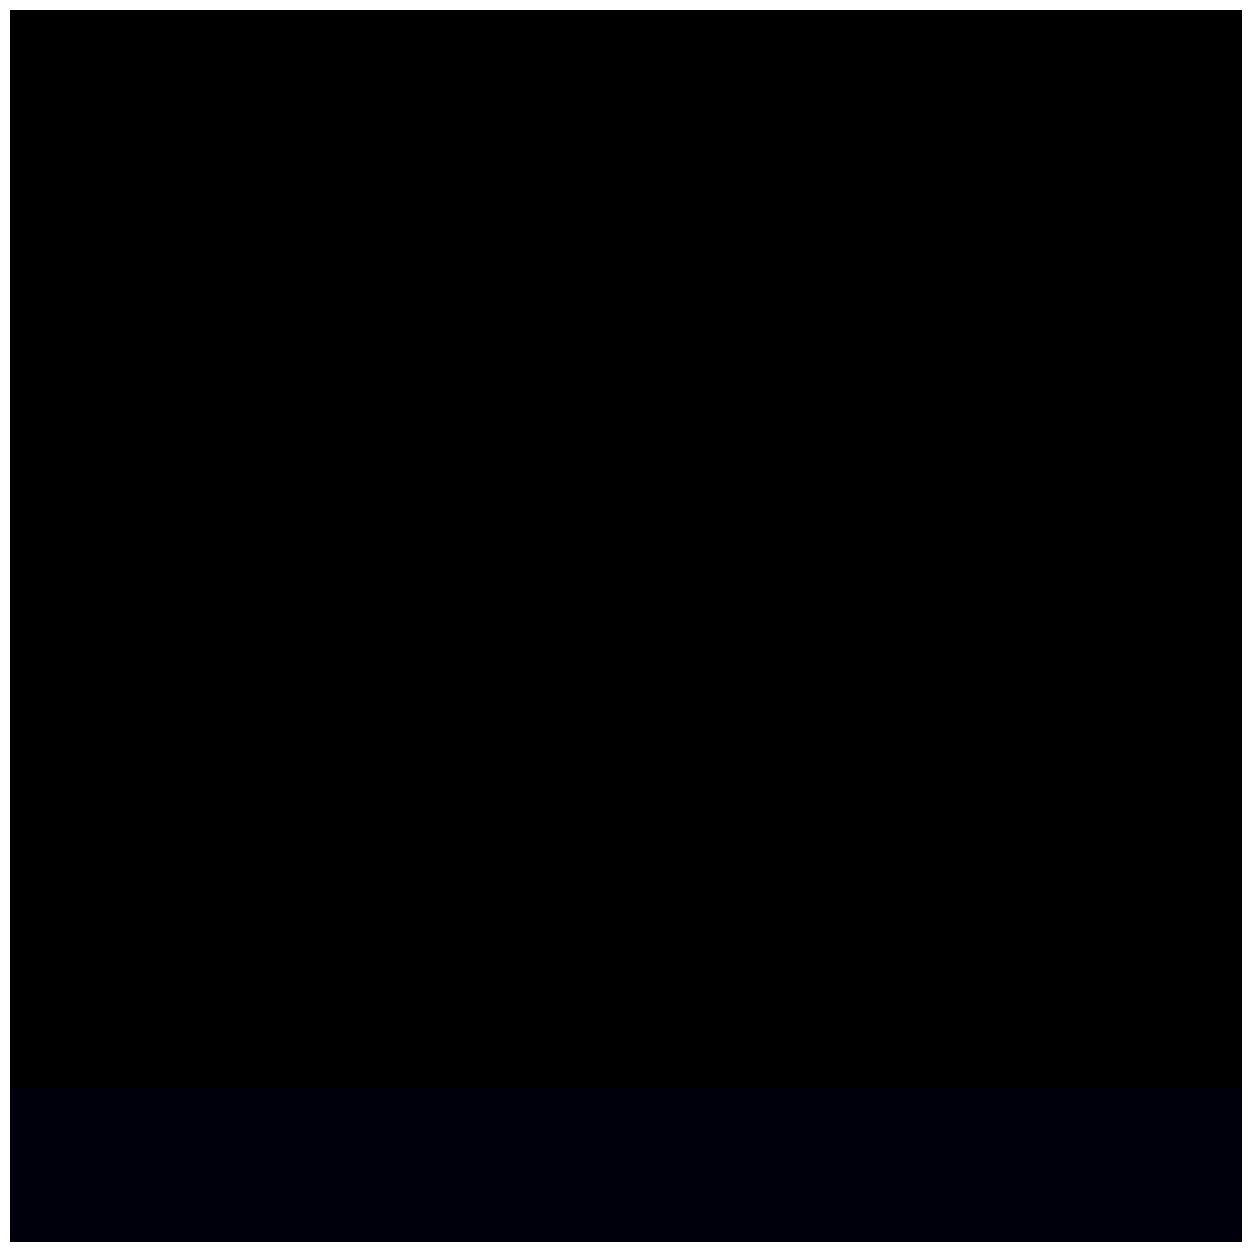

In [11]:
plot_channels(tensor)